## Libraries

In [78]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
from networkx.algorithms.link_prediction import jaccard_coefficient, adamic_adar_index
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Load network and node attributes

Number of nodes: 1500
Number of edges: 6600


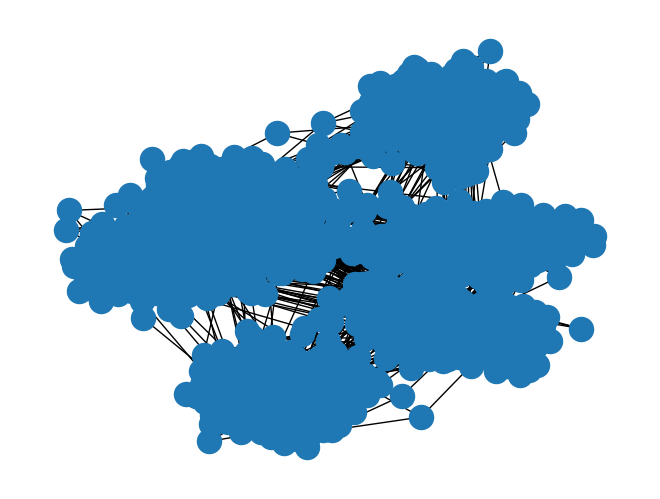

In [79]:
# Load network
G = nx.read_edgelist('edges_train.edgelist', delimiter=',', nodetype=int)

# Load node attributes
attributes = pd.read_csv('attributes.csv', header=None, names=['attribute'])

# Build mapping: node_id -> attribute_value
attr_map = dict(enumerate(attributes['attribute'].values))

nx.set_node_attributes(G, attr_map, name='attribute')

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# pos = nx.spring_layout(G)
nx.draw(G)


## Detect communities

Detected 6 communities.


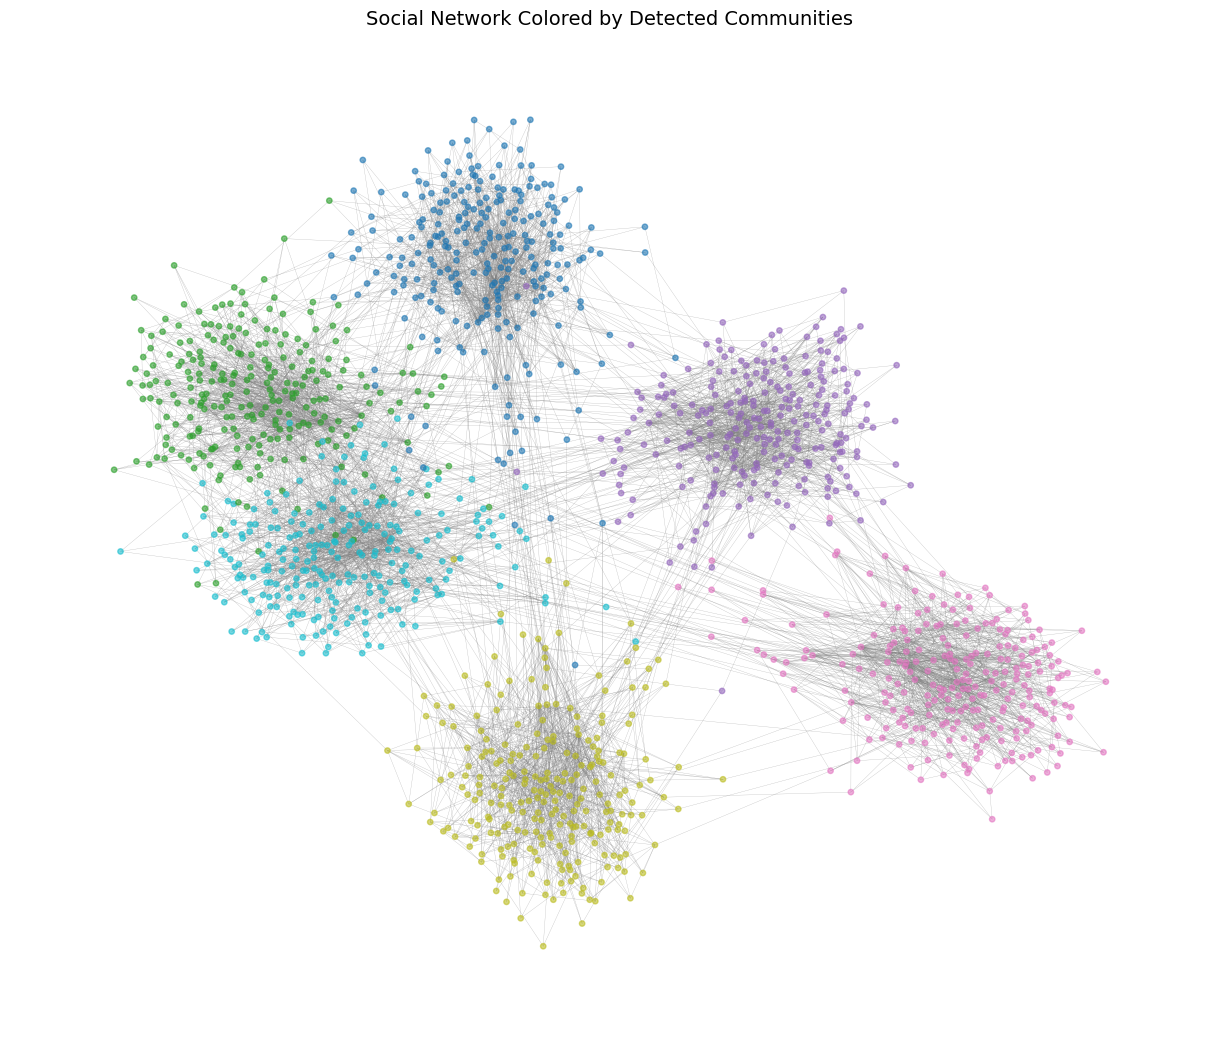

In [83]:
comms = list(greedy_modularity_communities(G))

print(f"Detected {len(comms)} communities.")

comm_id = {}
for cid, nodes in enumerate(comms):
    for n in nodes:
        comm_id[n] = cid

# Layout positions
pos = nx.spring_layout(G, seed=42, k=0.25, iterations=50)

# Color by community id
colors = [comm_id[n] for n in G.nodes()]

plt.figure(figsize=(12, 10))
nx.draw(
    G, pos,
    node_color=colors,
    cmap=plt.cm.tab10,
    node_size=15,
    edge_color="gray",
    width=0.2,
    alpha=0.6,
    with_labels=False
)
plt.title("Social Network Colored by Detected Communities", fontsize=14)
plt.show()

## Feature engineering

In [ ]:
def extract_features(G, u, v):
    
    # mutual friends
    common_neighbors = len(list(nx.common_neighbors(G, u, v))) 
    
    # how "social" is u, number of links of u
    degree_u = G.degree(u)
    
    # how "social" is v, number of links of v
    degree_v = G.degree(v) 

    # Same attribute between u and v
    attr_u = G.nodes[u]['attribute']
    attr_v = G.nodes[v]['attribute']
    same_attr = int(attr_u == attr_v) # 1 for true, 0 for false

    # Jaccard coefficient: Measures the fraction of mutual friends out of all possible friends of u and v
    jaccard = next(jaccard_coefficient(G, [(u, v)]))[2]

    # Adamic-Adar index: Weights 'rare' mutual friends more between u and v
    adamic_adar = next(adamic_adar_index(G, [(u, v)]))[2]

    # same community, 1 for true, 0 for false
    same_comm = int(any(u in c and v in c for c in comms))

    # Preferential attachment: people who are both very social are more likely to form new connections
    #pa = G.degree(u) * G.degree(v)
    # pa reduced our accuracy on kaggle, so we remove

    return [common_neighbors, degree_u, degree_v, same_attr, jaccard, adamic_adar, same_comm]


## Get positive and negative examples (edges)

In [85]:
# Positive examples (existing edges)
positive_edges = list(G.edges())
y_pos = np.ones(len(positive_edges))

# Negative examples (non-existent edges)
ranseed = np.random.RandomState(999)
non_edges = list(nx.non_edges(G))
ranseed.shuffle(non_edges) 
negative_edges = non_edges[:len(positive_edges)] # equal number of negative samples to balance dataset
y_neg = np.zeros(len(negative_edges))

# Combine
edges = positive_edges + negative_edges
y = np.concatenate([y_pos, y_neg])

# Compute features
X = np.array([extract_features(G, u, v) for u, v in edges])


## Train and test split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y # use stratify to preserve class balance
)

## Train supervised model, perform cross validation & grid search (hyperparameter optimization)

In [87]:
estimator = LogisticRegression(max_iter=2000, solver="liblinear")

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "C": np.logspace(-3, 3, 9), # regularization strength
    "penalty": ["l1", "l2"],
    "class_weight": [None, "balanced"]
}

gs = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring={"roc_auc": "roc_auc", "accuracy": "accuracy"},
    refit="roc_auc", 
    cv=cv,
    n_jobs=-1,
    verbose=0,
    return_train_score=False
)

# Fit grid search
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV ROC-AUC: %.3f" % gs.best_score_)

# Evaluate on the held-out test set with the best model
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC-AUC :", roc_auc_score(y_test, y_prob))


Best params: {'C': np.float64(1.0), 'class_weight': 'balanced', 'penalty': 'l1'}
Best CV ROC-AUC: 0.943
Test Accuracy: 0.8838383838383839
Test ROC-AUC : 0.9443623099683705


### Tested decision tree:

In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.metrics import accuracy_score, roc_auc_score

# model = DecisionTreeClassifier(
#     random_state=42,
#     max_depth=5,      # add 5 to avoid overfitting
#     min_samples_split=2,
#     min_samples_leaf=1,
# )

# # 5-fold CV on training set
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
# print("Cross-val accuracy: %.3f ± %.3f" % (cv_scores.mean(), cv_scores.std()))

# # Fit on all training data
# model.fit(X_train, y_train)

# # Evaluate on test set
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]

# print("Test Accuracy:", accuracy_score(y_test, y_pred))
# print("Test ROC-AUC :", roc_auc_score(y_test, y_prob))


### Tested random forest:

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold, cross_val_score
# from sklearn.metrics import accuracy_score, roc_auc_score

# model = RandomForestClassifier(
#     n_estimators=200,      # number of trees
#     max_depth=10,        # adjusted to 10 to avoid overfitting
#     min_samples_split=2,
#     min_samples_leaf=1,
#     random_state=42,
#     n_jobs=-1  
# )

# # Perform 5-fold cross-validation on the training set
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
# print("Cross-val accuracy: %.3f ± %.3f" % (cv_scores.mean(), cv_scores.std()))

# # Train on the full training set
# model.fit(X_train, y_train)

# # Evaluate on the unseen test set
# y_pred = model.predict(X_test)
# y_prob = model.predict_proba(X_test)[:, 1]  # class 1 probabilities

# print("Test Accuracy:", accuracy_score(y_test, y_pred))
# print("Test ROC-AUC :", roc_auc_score(y_test, y_prob))


Cross-val accuracy: 0.891 ± 0.007
Test Accuracy: 0.8815656565656566
Test ROC-AUC : 0.9327085246403428


## Make predictions using solutionInput.csv and generate output for Kaggle competition

In [88]:
test_pairs = pd.read_csv('solutionInput.csv')

# Extract features for test pairs
X_final = np.array([extract_features(G, int(u), int(v)) 
                    for u, v in zip(test_pairs['int1'], test_pairs['int2'])])

preds = best_model.predict(X_final)

# Save output for kaggle
output = pd.DataFrame({
    'ID': test_pairs.index,
    'Predicted': preds.astype(int)
})
output.to_csv('solutionOutput9.csv', index=False)

print("saved output solution")

saved output solution
